In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

----
### Ex 1

The parameter is $$\theta = \frac{E(X)}{E(U)}.$$ An estimator is $$\hat{\theta} = \frac{\sum_{i=1}^N{X_i}/N}{\sum_{i=1}^N{U}/N},$$ where $\{(X_1,U_1),\ldots,(X_N,U_N)\}$ is the data. 

In [4]:
df = pd.read_csv('/Users/francis/Desktop/bigcity.csv')[['u','x']]

In [8]:
estimate_from_sample = df['x'].mean() / df['u'].mean()
estimate_from_sample

1.2390185991294025

Bootstrap estimate of the bias and standard error of the above estimate:

In [22]:
def bootstrap_replicate(df, estimator):
    sample = df.sample(frac=1, replace=True)
    return estimator(sample)  

N = 1000; boot_estimates = np.empty(N)
for i in range(N):
    boot_estimates[i] = bootstrap_replicate(df, lambda x: x['x'].mean() / x['u'].mean())

In [25]:
# bootstrap bias
boot_estimates.mean() - estimate_from_sample

0.0016797241009367525

In [23]:
# bootstrap standard error
boot_se = boot_estimates.std()
boot_se

0.03358379103914602

The bootstrap confidence interval (percentile interval) is $(\hat{\theta}^*_{\alpha/2}, \hat{\theta}^*_{1-\alpha/2})$, where $\hat{\theta}^*_{\beta}$ is the $\beta$ quantile of our bootstrap estimates. In our case $\alpha = 0.1$, so the confidence interval is $(\hat{\theta}^*_{0.05}, \hat{\theta}^*_{0.95})$

In [24]:
conf_interval = np.quantile(boot_estimates, [0.05, 0.95])
conf_interval

array([1.18869825, 1.29768611])

----
### Ex 2

Suppose $X\sim F$, then $F(X)\sim U(0,1)$, so that $X\sim F^{-1}(U)$. We can first draw random samples $\{u_1,\ldots,u_n\}$ from the uniform distribution $U(0,1)$. Then $\{x_1=F^{-1}(u_1),\ldots,x_n=F^{-1}(u_n)\}$ should be a random sample from the $F$ distribution.

Now, the Weibull distribution given is:
$$F(y) = 1 - \exp\{-(y/\mu)^\alpha\},$$ so the inverse of $F$ is
$$F^{-1}(z) = \mu\cdot\left[\log\left(\frac{1}{1-z}\right)\right]^{1/\alpha}.$$

Note that since $Z\sim U(0,1)$ implies that $1-Z\sim U(0,1)$, drawing samples according to $F^{-1}$ is equivalent to drawing samples using $\mu\cdot\left(-\ln(U)\right)^{1/\alpha}$, which is how `numpy.random.weibull` is implemented (see [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.weibull.html#numpy.random.weibull))






In [31]:
def weibull_inverse(z, mu=1, alpha=5):
    return mu * np.log(1 / (1-z))** (1/alpha)

samples = weibull_inverse(np.random.uniform(size=10000))

The theoretical Weibull PDF is the first derivative of $F$, which is
$$f(x) = \frac{\alpha}{\mu}\left(\frac{x}{\mu}\right)^{\alpha-1}\cdot e^{-(\frac{x}{\mu})^\alpha}$$



In [35]:
def theoretical_weibull_pdf(x, mu=1, alpha=5):
    return (alpha / mu) * (x / mu)**(alpha-1) * np.exp(-(x/mu)**alpha)

Plot the sample distribution as well as the theoretical pdf. As one can see, the two density functions almost overlap:

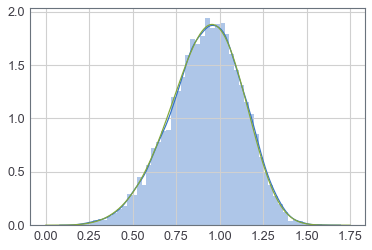

In [40]:
x = np.linspace(0, 1.75, num=500)
sns.distplot(tuple(samples))  # distribution from samples
plt.plot(x, theoretical_weibull_pdf(x))  # theoretical distribution
plt.show()

----
### Ex 3

In [47]:
def gaussian(x, mean, dev=0.1):
    return 1/(np.sqrt(2*np.pi)*dev)*np.exp(-(x-mean)**2/(2*dev**2))

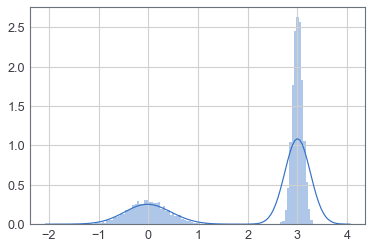

In [52]:
# True parameters is: [0, 3, 0.4, 0.1, 0.3]
N = 10000; a = 0.3
sample1 = np.random.normal(0, 0.4, size=int(N*a))
sample2 = np.random.normal(3, 0.1, size=int(N*(1-a)))
sample = np.concatenate([sample1, sample2])
sns.distplot(sample, bins=100)
plt.show()

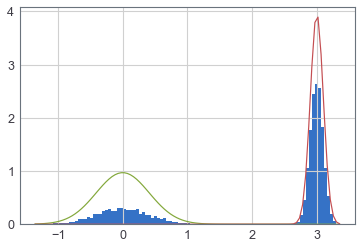

In [56]:
max_iter = 100
params = np.array([-1, 1, 1, 1, 0.5])
counter  = 0
converged = False
tol = 0.1
plabel_1 = np.zeros(sample.shape)
plabel_2 = np.zeros(sample.shape)
while not converged and counter < max_iter:
    counter = counter + 1
    mu1, mu2, sigma1, sigma2, pi_1 = params
    # Expectation Step
    for i in range(len(sample)):
        cdf1 = gaussian(sample[i], mu1, sigma1)
        cdf2 = gaussian(sample[i], mu2, sigma2)
        pi_2 = 1 - pi_1
        plabel_1[i] = cdf1 * pi_1 / (cdf1 * pi_1 + cdf2 * pi_2)
        plabel_2[i] = cdf2 * pi_2 / (cdf1 * pi_1 + cdf2 * pi_2)
    # Maximization Step
    mu1 = sum(plabel_1 * sample)/sum(plabel_1)
    mu2 = sum(plabel_2 * sample)/sum(plabel_2)
    sigma1 = np.sqrt(sum(plabel_1 * (sample - mu1) ** 2) / sum(plabel_1))  # std.
    sigma2 = np.sqrt(sum(plabel_2 * (sample - mu2) ** 2) / sum(plabel_2))  # std.
    pi_1 = sum(plabel_1) / len(sample)
    new_paramaters = np.array([mu1, mu2, sigma1, sigma2, pi_1])
    print(new_paramaters)
    
    # Check convergence
    if np.max(abs(np.asarray(params) - np.asarray(new_paramaters))) < tol:
        converged = True
    params = new_paramaters

plt.hist(sample, bins=100, density=True)
x = np.linspace(sample.min(), sample.max(), 100)
plt.plot(x, norm.pdf(x, mu1, sigma1))
plt.plot(x, norm.pdf(x, mu2, sigma2))
plt.show()

----
### Ex 4

$$f(x;\delta) =
\begin{cases}
\frac{\delta}{x\sqrt{2\pi}}\cosh\{\delta\log(2x)\}\exp\{-\sinh\{\delta\log(2x)\}^2/2\} & \text{ for }x > 0\\
0 & \text{ otherwise.} 
\end{cases}
$$

In [114]:
# Distribution of X
def f(x, delta=1.5):
    if x <= 0: return 0
    component = delta * np.log(2*x)
    return (delta /(x*np.sqrt(2*np.pi))) * np.cosh(component) * np.exp(-np.sinh((component)**2) /2)

# turn f into a numpy universal function (its number of input is 1, and number of output is 1)
uf = np.frompyfunc(f, 1, 1)

In [166]:
x = np.linspace(0,5,5000)

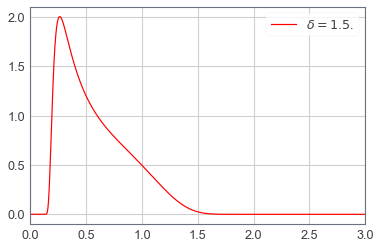

In [167]:
plt.plot(x, uf(x), color='red', label='$\delta=1.5$.')
plt.xlim([0,3])
plt.legend()
plt.show()

The exponential PDF is $$g(x) = \lambda e^{-\lambda x}, \quad\lambda > 0.$$ 

In [125]:
# Envelope - Exponential distribution
def g(x, _lambda=1):
    return expon.pdf(x, scale=1 /_lambda)

We let $\alpha = \mathrm{argmax}_{x\in S}\{f(x)/g(x)\}$, where $S=[0,\infty)$. In this case $f(x)\leq \alpha g(x)$ for all $x\in S$. The acceptance-rejection method for sampling is as follows:

Repeatedly draw sample $x$ from $g$ and uniform sample $u$ from $U(0,1)$. If $$u\leq\frac{f(x)}{\alpha g(x)}$$ then we accept $x$, otherwise we reject $x$.

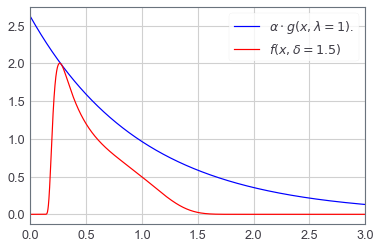

In [168]:
alpha = max(uf(x)/g(x))  # alpha
plt.plot(x, alpha*g(x), color='blue', label=r'$\alpha\cdot g(x,\lambda=1)$.')
plt.plot(x, uf(x), color='red', label='$f(x,\delta=1.5)$')
plt.xlim([0,3])
plt.legend()
plt.show()

In [153]:
def accept_reject(iterations):
    generated_samples = []
    for i in range(iterations):
        x = np.random.exponential()
        u = np.random.uniform(0, 1)
        if u <= uf(x)/(g(x)*alpha):
            generated_samples.append(x)
    return np.array(generated_samples)

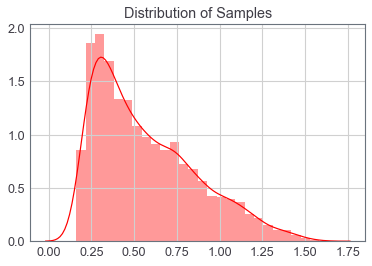

In [169]:
samples = accept_reject(10000)
sns.distplot(samples, color='red')
plt.title('Distribution of Samples')
plt.show()

Our estimate of $E(X^2)$ from sample $\{x_1,\ldots,x_N\}$ is $$\frac{\sum_{i=1}^N x^2_i}{N},$$ where $N$ is the sample size:

In [174]:
# the function `second_moment` is an estimator of the second moment of the random variable that generates the data.
def second_moment(data):
    return np.mean(data**2)
estimate = second_moment(samples)
estimate

0.4127292415140635

We now use bootstrap to get the standard error and confidence interval of our estimate:

In [203]:
"""
Return bootstrap standard error and confidence interval of an estimator.
"""
def bootstrap(data, estimator, N=1000, alpha=0.1):
    estimate = estimator(data)
    boot_estimates = np.empty(N)
    for i in range(N):
        boot_data = np.random.choice(data, len(data))
        boot_estimates[i] = estimator(boot_data)  
    
    std = np.std(boot_estimates)
    confidence_interval = np.quantile(boot_estimates, [alpha/2, 1-alpha/2])
    return std, confidence_interval

In [207]:
std, confidence_interval = bootstrap(samples, estimator=second_moment)
print(f"""The bootstrap standard error is {std:.4}.\n
The bootstrap conficence interval is {confidence_interval}
""")  

The bootstrap standard error is 0.0067.

The bootstrap conficence interval is [0.40020105 0.42331526]

